In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys
import time

from scipy.stats import pearsonr

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [4]:
import xgboost as xgb

class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

class SklearnWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

## try scipy.stats.pearsonr

In [7]:
x = np.arange(10).astype(np.float32)

print(pearsonr(x, x ** 2))
print(pearsonr(x, -x))
print(pearsonr(x, 2 * x))

x[0] = np.NaN

print(pearsonr(x, x ** 2))
print(pearsonr(x, -x))
print(pearsonr(x, 2 * x))

(0.9626907, 8.103413702351178e-06)
(-1.0, 0.0)
(1.0, 0.0)
(nan, 1.0)
(nan, 1.0)
(nan, 1.0)


In [8]:
def corr(x, y):
    x, y = x.copy(), y.copy()
    x[np.isnan(x)] = 0.0
    y[np.isnan(y)] = 0.0
    return np.abs(pearsonr(x, y)[0])

x = np.arange(10).astype(np.float32)

print(corr(x, x ** 2))
print(corr(x, -x))
print(corr(x, 2 * x))

x[0] = np.NaN

print(corr(x, x ** 2))
print(corr(x, -x))
print(corr(x, 2 * x))

0.9626907
1.0
1.0
0.9626907
1.0
1.0


## data & test

In [9]:
data = load_dataframe32("./bindata/data_013")
data["SK_ID_CURR"] = data.SK_ID_CURR.astype("int")

test = load_dataframe32("./bindata/test_013")
test["SK_ID_CURR"] = test.SK_ID_CURR.astype("int")

y = load_dataframe32("./bindata/y_013")
y["SK_ID_CURR"] = y.SK_ID_CURR.astype("int")

features_selected = list(np.load("./models/features-selected-016.npy"))

In [10]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data = data.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    test = test.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    del nmf_data
    gc.collect()
    
buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()
    
for name in (
    "./bindata/bureau_and_balance_015",
    "./bindata/previous_applications_015",
    "./bindata/pos_cash_015",
    "./bindata/installments_payments_015",
    "./bindata/credit_card_balance_015",
):
    data_ = load_dataframe32(name)
    data_["SK_ID_CURR"] = data_.SK_ID_CURR.astype("int")
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

In [11]:
X = data[features_selected].values

In [12]:
sys.getsizeof(X), X.shape

(112, (307507, 1250))

In [ ]:
def select_by_corr(X, th):
    keep = [0]
    remove_map = {0: []}
    corr_mat = {}
    for i, ftr_ in enumerate(features_selected):
        if i in keep:
            continue

        keep_flag = True
        for j in keep:
            corr_ij = corr(X[:, i], X[:, j])
            corr_mat[(i, j)] = corr_ij

            if corr_ij > th:
                keep_flag = False
                remove_map[j].append(i)
                break

        if keep_flag:
            keep.append(i)
            remove_map[i] = []
    return keep, remove_map, corr_mat

## do selection on data[features_selected]

In [ ]:
keep, remove_map, corr_mat = select_by_corr(X, .8)

In [ ]:
max(corr_mat.values())

In [ ]:
sum(v == 1 for v in corr_mat.values())

In [ ]:
len(keep)

In [33]:
features_selected_20 = np.array(features_selected)[keep]
np.save("./models/features-selected-020", features_selected_20)

## remove less

In [ ]:
dup = [key[0] for key, val in corr_mat.items() if val == 1.0]

features_selected_20_less = [col_ for i, col_ in enumerate(features_selected) if i not in dup]
np.save("./models/features-selected-0201", features_selected_20_less)

## train & validate

In [35]:
data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

In [36]:
data_train.shape

(25803, 2030)

In [39]:
X_num_train = data_train[features_selected_20].values
X_num_val = data_val[features_selected_20].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7676246095871037

In [48]:
dup = [key[0] for key, val in corr_mat.items() if val == 1.0]
features_selected_20_less = [col_ for i, col_ in enumerate(features_selected) if i not in dup]

X_num_train = data_train[features_selected_20_less].values
X_num_val = data_val[features_selected_20_less].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7680950455454033

## make submission

In [41]:
a = time.time()

features_selected_20 = list(np.load("./models/features-selected-020.npy"))
seed = 0


X_data = data[features_selected_20].values
X_test = test[features_selected_20].values
gc.collect()

print("seed", seed)
print(X_data.shape, X_test.shape)

y_data = y.TARGET.values


lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-020-nround2000-fs20-rd{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-020-lgb2000-fs20-rd{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-020-lgb2000-fs20-rd{}.csv".format(seed), index=False)

seed 0
(307507, 775) (48744, 775)
0.016750959555308025
15.479918734232585
0.07988790671030681


In [49]:
a = time.time()

dup = [key[0] for key, val in corr_mat.items() if val == 1.0]
features_selected_20_less = [col_ for i, col_ in enumerate(features_selected) if i not in dup]
seed = 0

X_data = data[features_selected_20_less].values
X_test = test[features_selected_20_less].values
gc.collect()

print("seed", seed)
print(X_data.shape, X_test.shape)

y_data = y.TARGET.values


lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-020-nround2000-fs201-rd{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-020-lgb2000-fs201-rd{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-020-lgb2000-fs201-rd{}.csv".format(seed), index=False)

seed 0
(307507, 1150) (48744, 1150)
0.02630150318145752
25.026764782269797
0.11103968620300293


## bayesian optimization --subset

In [52]:
import lightgbm as lgb

from bayes_opt import BayesianOptimization

In [65]:
train_data = lgb.Dataset(data=X_num_train, label=y_train)
n_folds = 2
random_seed = 0

def target_function(num_leaves,
                    colsample_bytree,
                    subsample,
                    subsample_freq,
                    max_depth,
                    reg_alpha,
                    reg_lambda,
                    min_split_gain,
                    min_child_weight):
    global train_data, nfolds, random_seed
    params = {
        "nthread": 8,
        "n_estimators": 250, # 2000,
        "learning_rate": 0.02,
        "random_state": 0,
        'metric':'auc',
        "silent": -1,
        "verbose": -1,
        # "num_leaves": 34,
        # "colsample_bytree": 0.9497036,
        # "subsample": 0.8715623,
        # "subsample_freq": 1,
        # "max_depth": 8,
        # "reg_alpha": 0.041545473,
        # "reg_lambda": 0.0735294,
        # "min_split_gain": 0.0222415,
        # "min_child_weight": 39.3259775,
    }
    params["num_leaves"] = int(round(num_leaves))
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0.1)
    params['subsample'] = max(min(subsample, 1), 0.1)
    params['subsample_freq'] = int(round(subsample_freq))
    params['max_depth'] = int(round(max_depth))
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lambda'] = max(reg_lambda, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =50, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [66]:
lgbBO = BayesianOptimization(
    target_function,
    {
        "num_leaves": (30, 45),
        "colsample_bytree": (.7, .99),
        "subsample": (.7, .99),
        "subsample_freq": (1, 5),
        "max_depth": (6, 10),
        "reg_alpha": (.0, .1),
        "reg_lambda": (.0, .1),
        "min_split_gain": (.0, .1),
        "min_child_weight": (30, 45),
    },
    random_state=0)

In [67]:
lgbBO.maximize(init_points=10, n_iter=20)

Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample |   subsample_freq | 
[50]	cv_agg's auc: 0.737465 + 0.00471036
[100]	cv_agg's auc: 0.741807 + 0.00502509
[150]	cv_agg's auc: 0.745825 + 0.00457703
[200]	cv_agg's auc: 0.747252 + 0.00340129
[250]	cv_agg's auc: 0.746426 + 0.00357624
    1 | 00m51s |    0.74758 |             0.9296 |      7.4380 |            34.7697 |           0.0976 |      38.2322 |      0.0570 |       0.0159 |      0.9838 |           2.0582 | 
[50]	cv_agg's auc: 0.737889 + 0.00804477
[100]	cv_agg's auc: 0.742806 + 0.00890373
[150]	cv_agg's auc: 0.747109 + 0.00750601
[200]	cv_agg's auc: 0.748414 + 0.00677344
[250]	cv_agg's auc: 0.746824 + 0.00538624
    2 | 01m00s |   

[50]	cv_agg's auc: 0.736052 + 0.00472278
[100]	cv_agg's auc: 0.742259 + 0.00649679
[150]	cv_agg's auc: 0.747723 + 0.00509546
[200]	cv_agg's auc: 0.749084 + 0.004445
[250]	cv_agg's auc: 0.748469 + 0.00380065
   19 | 01m17s |    0.74997 |             0.7954 |      9.9797 |            30.0023 |           0.0923 |      30.9836 |      0.0652 |       0.0308 |      0.9167 |           4.5956 | 
[50]	cv_agg's auc: 0.738202 + 0.00904526
[100]	cv_agg's auc: 0.745058 + 0.00679577
[150]	cv_agg's auc: 0.745904 + 0.00481763
[200]	cv_agg's auc: 0.746007 + 0.00476226
[250]	cv_agg's auc: 0.74627 + 0.00439097
   20 | 01m25s |    0.74670 |             0.9275 |      9.9768 |            44.1335 |           0.0663 |      39.5412 |      0.0996 |       0.0193 |      0.9444 |           1.0257 | 
[50]	cv_agg's auc: 0.738858 + 0.00798491
[100]	cv_agg's auc: 0.745681 + 0.00678437
[150]	cv_agg's auc: 0.749785 + 0.00605856
[200]	cv_agg's auc: 0.752286 + 0.00561546
[250]	cv_agg's auc: 0.751769 + 0.00361549
   21 | 01

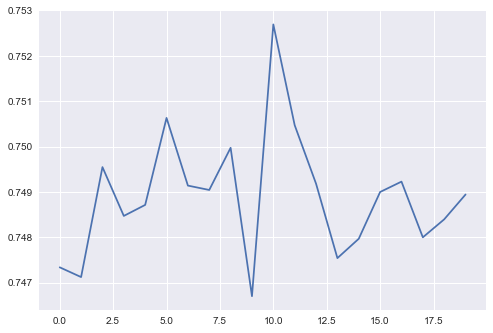

In [70]:
plt.plot(lgbBO.res["all"]["values"])
plt.show()

In [72]:
lgbBO.res["max"]["max_params"]

{'colsample_bytree': 0.7507521452114979,
 'max_depth': 9.876298947569682,
 'min_child_weight': 30.49556775046322,
 'min_split_gain': 0.09159674279901034,
 'num_leaves': 30.128761469018812,
 'reg_alpha': 0.09274254633966617,
 'reg_lambda': 0.005176611637954099,
 'subsample': 0.7027356589192597,
 'subsample_freq': 1.1354253892533}

In [74]:
dup = [key[0] for key, val in corr_mat.items() if val == 1.0]
features_selected_20_less = [col_ for i, col_ in enumerate(features_selected) if i not in dup]

X_num_train = data_train[features_selected_20_less].values
X_num_val = data_val[features_selected_20_less].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 30,
    "colsample_bytree": 0.7507521452114979,
    "subsample": 0.7027356589192597,
    "subsample_freq": 1,
    "max_depth": 10,
    "reg_alpha": 0.09274254633966617,
    "reg_lambda": 0.0051766116379540994,
    "min_split_gain": 0.09159674279901034,
    "min_child_weight": 30.49556775046322,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7699004375001968

In [75]:
del data_train, data_val, X_num_train, X_num_val
gc.collect()

6037

## bayesian optimization

In [79]:
dup = [key[0] for key, val in corr_mat.items() if val == 1.0]

features_selected_20_less = [col_ for i, col_ in enumerate(features_selected) if i not in dup]

X = data[features_selected_20_less].values
y_data = y.TARGET.values

gc.collect()

train_data = lgb.Dataset(data=X, label=y_data)
n_folds = 5
random_seed = 0

def target_function(num_leaves,
                    colsample_bytree,
                    subsample,
                    subsample_freq,
                    max_depth,
                    reg_alpha,
                    reg_lambda,
                    min_split_gain,
                    min_child_weight):
    global train_data, nfolds, random_seed
    params = {
        "nthread": 8,
        "n_estimators": 2000,
        "learning_rate": 0.02,
        "random_state": 0,
        'metric':'auc',
        "silent": -1,
        "verbose": -1
    }
    params["num_leaves"] = int(round(num_leaves))
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0.1)
    params['subsample'] = max(min(subsample, 1), 0.1)
    params['subsample_freq'] = int(round(subsample_freq))
    params['max_depth'] = int(round(max_depth))
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lambda'] = max(reg_lambda, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =1000, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [ ]:
lgbBO = BayesianOptimization(
    target_function,
    {
        "num_leaves": (28, 45),
        "colsample_bytree": (.65, .99),
        "subsample": (.65, .99),
        "subsample_freq": (1, 3),
        "max_depth": (6, 12),
        "reg_alpha": (.0, .2),
        "reg_lambda": (.0, .2),
        "min_split_gain": (.0, .2),
        "min_child_weight": (30, 45),
    },
    random_state=0)

lgbBO.maximize(init_points=10, n_iter=50, acq='ei', xi=0.0)

Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample |   subsample_freq | 
